# Capstone 1: Inferential Statistics

<a id='TOC'></a>
**Table of Contents**
1. Preliminaries
    1. [Import EMS Incident Data](#Sec01A)
    2. [Preprocess Dataset](#Sec01B)
    3. [Segment Variables](#Sec01C)
2. Preliminary Statistics
    1. [Correlations between Numerical Variables](#Sec02A)
    2. [Association between Categorical Variables](#Sec02B)
3. Response Times
    1. [Preliminary Data Inspection & Summary Statistics](#Sec03A)
    2. [Sample Statistics by Outcome Group](#Sec03B) 
    3. [Frequentist Test](#Sec03C)

The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.

Various inferential statistics techniques were performed on the dataset prior to the development of any ML algorithms. One purpose of this process was to examine the correlations between all variables within the dataset in greater depth than preliminary EDA permits. In addition, any feature variable that has a significant impact on the target variable (`fatality`) will also be revealed through these measures.

## 1. PRELIMINARIES

<a id='Sec01A'></a>
#### 1A: Import EMS incident data

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np

import pandas_profiling

from scipy import stats
from statsmodels.stats.weightstats import ztest, ttest_ind

from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
sb.set(style='whitegrid', palette='pastel', color_codes=True)
sb.mpl.rc('figure', figsize=(15,10))

In [2]:
# Assign file path
file_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(file_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
#df.info(verbose=True,memory_usage='deep')

[TOC](#TOC)

<a id="Sec01B"></a>
#### 1B: Preprocess Dataset

In [4]:
# Change dtypes
df['weekday'] = df.weekday.astype('category')
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['incident_disposition_code'] = df.incident_disposition_code.astype('category')

In [5]:
# Remove immaterial columns
list_of_cols = ['latitude','longitude',
                'aland_sqmi','awater_sqmi','held_indicator',
                'first_assignment_datetime','incident_dispatch_area',
                'first_activation_datetime','first_on_scene_datetime',
                'first_to_hosp_datetime','first_hosp_arrival_datetime',
                'incident_close_datetime']
df.drop(list_of_cols,axis=1,inplace=True)

In [6]:
#df.info(verbose=True,memory_usage='deep')

In [7]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,initial_call_type,initial_severity_level,final_call_type,final_severity_level,dispatch_time,travel_time,response_time,incident_disposition_code,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,BRONX,10472.0,RESPIR,4,RESPIR,4,101,696.0,797.0,82.0,False,False
2013-01-01 00:05:52,2013,1,1,0,2,BRONX,10472.0,EDP,7,EDP,7,12,522.0,534.0,82.0,False,False
2013-01-01 00:20:37,2013,1,1,0,2,BRONX,10472.0,SICK,6,SICK,6,52,645.0,697.0,93.0,False,False
2013-01-01 01:53:11,2013,1,1,1,2,BRONX,10472.0,INJURY,4,INJURY,4,25,198.0,223.0,82.0,False,False
2013-01-01 01:54:28,2013,1,1,1,2,BRONX,10472.0,SICK,4,SICK,4,42,256.0,298.0,82.0,False,False


[TOC](#TOC)

<a id="Sec01C"></a>
#### 1C: Segment  Variables

In [8]:
# Numeric feature variables
num_var = ['year','month','day','hour','dispatch_time','travel_time','response_time']
x1 = df[num_var]

# Categorical feature variables
cat_var = ['weekday','borough','zipcode','final_call_type','final_severity_level','life_threatening']
x2 = df[cat_var]

# Target variable
Y = df[['fatality']]

In [9]:
X1 = x1.values
X2 = x2.values
y = Y.values
print("X1: ", type(X1), X1.shape)
print("X2: ", type(X2), X2.shape)
print("y: ", type(y), y.shape)

X1:  <class 'numpy.ndarray'> (7988028, 7)
X2:  <class 'numpy.ndarray'> (7988028, 6)
y:  <class 'numpy.ndarray'> (7988028, 1)


[TOC](#TOC)

*** 

## 2. PRELIMINARY STATISTICS

<a id='Sec02A'></a>
#### 2A: Correlations between Numerical Variables

What is the correlation between pairs of similar _numerical_ variables within the dataset?
* `initial_severity_level` and `final_severity_level`
* `dispatch_time` and `response_time`
* `travel_time` and `response_time`

In [12]:
# Correlation - Initial and Final Severity Levels
x1 = df.initial_severity_level.values
y1 = df.final_severity_level.values
rho1 = np.corrcoef(x1,y1)[0][1]

# Correlation - Dispatch and Response Times
x2 = df.dispatch_time.values
y2 = df.response_time.values
rho2 = np.corrcoef(x2,y2)[0][1]

# Correlation - Travel and Response Times
x3 = df.travel_time.values
y3 = df.response_time.values
rho3 = np.corrcoef(x3,y3)[0][1]

# Output correlation statistics
print('Initial vs. Final Severity Level: \u03C1 = {:.4f}'.format(rho1))
print('Dispatch vs. Response Times:      \u03C1 = {:.4f}'.format(rho2))
print('Travel vs. Response Times:        \u03C1 = {:.4f}'.format(rho3))

Initial vs. Final Severity Level: ρ = 0.9352
Dispatch vs. Response Times:      ρ = 0.7731
Travel vs. Response Times:        ρ = 0.7476


There is a strong correlation between the `initial_severity_level` and the `final_severity_level` ($\rho = 0.9352$). This indicates that the determination for the severity of an incident made by dispatch--based on the information obtained by a caller--closely aligns with the determination made by on-scene EMS crew. Similarly, there are moderately strong correlations between the `response_time` and both `dispatch_time` ($\rho = 0.7731$) and `travel_time` ($\rho = 0.7476$).

For these reasons, the `initial_severity_level`, `dispatch_time` and `travel_time` will all be omitted from any analyses used to develop ML algorithms given they are redundant predictor variable. [TOC](#TOC)

<a id="Sec02B"></a>
#### 2B: Association between Categorical Variables

What is the association between pairs of similar _categorical_ variables within the dataset?
* `initial_call_type` and `final_call_type`

In [13]:
# Define Cramér's V
def cramers_v(confusion_matrix,corrected=False):
    """
    Calculate Cramer's V statistic for measure of association
    between two categorical features
    """
    # Calculate phi coefficient
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    
    r,k = confusion_matrix.shape

    # Calculate Cramér's statistic
    cV = np.sqrt(phi2/(min(k-1,r-1)))
    
    # Calculate bias corrections
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)
    
    # Calculate corrected Cramér's statistic
    cVcorr = np.sqrt(phi2corr/(min(kcorr-1,rcorr-1)))
    
    if corrected==False:
        statistic = cV
    else:
        statistic = cVcorr
    
    return statistic

In [14]:
# Create confusion matrix for features
confusion_matrix = pd.crosstab(df.initial_call_type,df.final_call_type).values

# Calculate Cramér's V statistics
cV_stat = cramers_v(confusion_matrix)
cVcorr_stat = cramers_v(confusion_matrix,True) #corrected_cramers_v(confusion_matrix)
print('Cramér\'s V Statistic:           {:.4f}'.format(cV_stat))
print('Corrected Cramér\'s V Statistic: {:.4f}'.format(cVcorr_stat))

Cramér's V Statistic:           0.7552
Corrected Cramér's V Statistic: 0.7552


There is a moderately strong association between the `initial_call_type` and the `final_call_type`. This indicates that the determination for the incident call type made by dispatch--based on the information obtained by a caller--aligns closely to the determination made by on-scene EMS crew.

For this reason, the `initial_call_type` will be omitted from any analyses used to develop ML algorithms given that it is a redundant predictor variable. [TOC](#TOC)

***

## 3. Response Times

<a id='Sec03A'></a>
#### 3A: Preliminary Data Inspection & Summary Statistics

In [47]:
rspn_tm = df[['response_time','fatality']]
#rspn_tm.head()

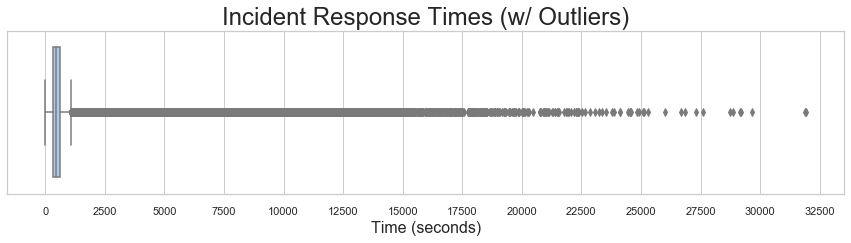

In [48]:
# Visualize spread of response times
fig3A1, ax3A1 = plt.subplots(figsize=(15,3))
ax3A1 = sb.boxplot(x='response_time',
                  data=rspn_tm,
                  orient='h')
ax3A1.set_title('Incident Response Times (w/ Outliers)',size=24)
ax3A1.set_xlabel('Time (seconds)',size=16)
ax3A1.set_xticks([2500*i for i in range(14)])
ax3A1.set_ylabel('',size=16)

#plt.savefig('../graphics/CP1-03_fig03A1.png') # Export plot to PNG file
plt.show()

In [56]:
# Calculate summary statistics
mean_rspn_tm = np.mean(rspn_tm.response_time)
quartiles = np.percentile(rspn_tm.response_time,[25,50,75])
median_rspn_tm = np.median(rspn_tm.response_time)
min_rspn_tm, max_rspn_tm = rspn_tm.response_time.min(),rspn_tm.response_time.max()

# Identify outliers
maxf_rspn_tm = quartiles[2]+1.5*(quartiles[2]-quartiles[0]) # "Maximum" (Q3 + 1.5*IQR)
outliers = rspn_tm.response_time[rspn_tm.response_time>maxf_rspn_tm]

# Output statistics
print('SUMMARY STATISTICS (Original)')
print('Total Number of Observations: {:8}'.format(len(rspn_tm.response_time)))
print('Number of Outliers:           {:8}\n'.format(len(outliers)))
print('Mean:        {:8.2f}'.format(mean_rspn_tm))
print('Q1:          {:8.2f}'.format(quartiles[0]))
print('Median (Q2): {:8.2f}'.format(quartiles[1]))
print('Q3:          {:8.2f}\n'.format(quartiles[2]))
print('Actual Minimum Response Time:          {:9.2f}'.format(min_rspn_tm))
print('\"Maximum\" Response Time (Q3 + 1.5*IQR):{:9.2f}'.format(maxf_rspn_tm))
print('Actual Maximum Response Time:          {:9.2f}'.format(max_rspn_tm))

SUMMARY STATISTICS (Original)
Total Number of Observations:  7988028
Number of Outliers:             576867

Mean:          561.09
Q1:            312.00
Median (Q2):   438.00
Q3:            626.00

Actual Minimum Response Time:               1.00
"Maximum" Response Time (Q3 + 1.5*IQR):  1097.00
Actual Maximum Response Time:           31931.00


The summary statistics above indicate there are a large number of outliers contained within this dataset. Therefore, the spread of `response_time` should be examined without these values to convolute the trends.

In [57]:
# Remove outlier observations from data
rspn_tm_adj = rspn_tm[rspn_tm.response_time<=maxf_rspn_tm]

# Calculate summary statistics
mean_rspn_tm_adj = np.mean(rspn_tm_adj.response_time)
quartiles_adj = np.percentile(rspn_tm_adj.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_adj.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_adj.response_time.min(),rspn_tm_adj.response_time.max()

# Output statistics
print('SUMMARY STATISTICS (w/o Orig. Outliers)')
print('Total Number of Observations: {:8}\n'.format(len(rspn_tm_adj.response_time)))
print('Mean:        {:8.2f}'.format(mean_rspn_tm_adj))
print('Q1:          {:8.2f}'.format(quartiles_adj[0]))
print('Median (Q2): {:8.2f}'.format(quartiles_adj[1]))
print('Q3:          {:8.2f}\n'.format(quartiles_adj[2]))
print('Actual Minimum Response Time: {:9.2f}'.format(min_rspn_tm_adj))
print('Actual Maximum Response Time: {:9.2f}'.format(max_rspn_tm_adj))

SUMMARY STATISTICS (w/o Orig. Outliers)
Total Number of Observations:  7411161

Mean:          454.18
Q1:            303.00
Median (Q2):   419.00
Q3:            572.00

Actual Minimum Response Time:      1.00
Actual Maximum Response Time:   1097.00


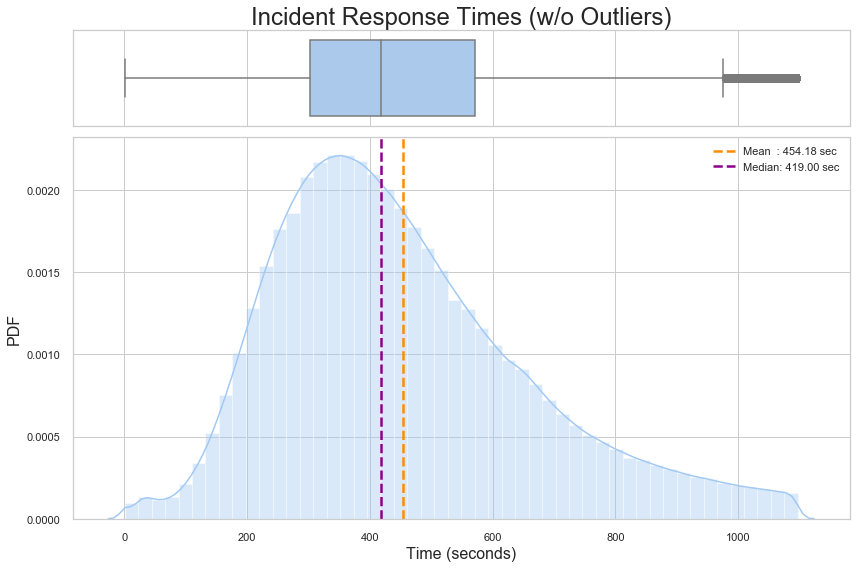

In [58]:
# Visualize boxplot and distribution of response times
fig3A2, ax3A2 = plt.subplots(2,figsize=(12,8),sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
sb.boxplot(rspn_tm_adj.response_time, ax=ax3A2[0])
sb.distplot(rspn_tm_adj.response_time, ax=ax3A2[1])
ax3A2[0].set_title('Incident Response Times (w/o Outliers)',size=24)
ax3A2[0].set_xlabel('')
ax3A2[1].set_xlabel('Time (seconds)',size=16)
ax3A2[1].set_ylabel('PDF',size=16)

# Visualize mean and median response times
measurements = [mean_rspn_tm_adj,median_rspn_tm_adj]
names = ['Mean','Median']
colors = ['darkorange','darkmagenta']
for m, n, c in zip(measurements, names, colors):
    plt.axvline(x=m,linestyle='--',linewidth=2.5,label='{0:6}: {1:.2f} sec'.format(n,m),c=c)

plt.legend()
plt.tight_layout()
#plt.savefig('../graphics/CP1-03_fig03A2.png') # Export plot to PNG file
plt.show()

The distribution of incident response times is positively-skewed. All remaining observations will be parsed into two, independent samples based on the incident outcome: __fatalities__ (`fatality == True`) and __survivals__ (`fatality == False`). [TOC](#TOC)

<a id="Sec03B"></a>
#### 3B: Summary Statistics by Outcome Group

In [71]:
rspn_tm_F = rspn_tm_adj[rspn_tm_adj.fatality==True]  # fatalities

# Calculate summary statistics for fatalities
mean_rspn_tm_adj = np.mean(rspn_tm_F.response_time)
SE_rspn_tm_adj = stats.sem(rspn_tm_F.response_time)
quartiles_adj = np.percentile(rspn_tm_F.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_F.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_F.response_time.min(),rspn_tm_F.response_time.max()

# Output statistics
print('SUMMARY STATISTICS: Fatalities (w/o Orig. Outliers)')
print('Total Number of Observations: {:8}\n'.format(len(rspn_tm_F.response_time)))
print('Mean:        {:8.2f}'.format(mean_rspn_tm_adj))
print('Std. Error:  {:8.2f}\n'.format(SE_rspn_tm_adj))
print('Q1:          {:8.2f}'.format(quartiles_adj[0]))
print('Median (Q2): {:8.2f}'.format(quartiles_adj[1]))
print('Q3:          {:8.2f}\n'.format(quartiles_adj[2]))
print('Actual Minimum Response Time: {:9.2f}'.format(min_rspn_tm_adj))
print('Actual Maximum Response Time: {:9.2f}'.format(max_rspn_tm_adj))

SUMMARY STATISTICS: Fatalities (w/o Orig. Outliers)
Total Number of Observations:   291382

Mean:          462.11
Std. Error:      0.41

Q1:            297.00
Median (Q2):   420.00
Q3:            593.00

Actual Minimum Response Time:      1.00
Actual Maximum Response Time:   1097.00


In [69]:
rspn_tm_S = rspn_tm_adj[rspn_tm_adj.fatality==False] # survivals

# Calculate summary statistics for survivals
mean_rspn_tm_adj = np.mean(rspn_tm_S.response_time)
SE_rspn_tm_adj = stats.sem(rspn_tm_S.response_time)
quartiles_adj = np.percentile(rspn_tm_S.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_S.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_S.response_time.min(),rspn_tm_S.response_time.max()

# Output statistics
print('SUMMARY STATISTICS: Survivals (w/o Orig. Outliers)')
print('Total Number of Observations: {:8}\n'.format(len(rspn_tm_S.response_time)))
print('Mean:        {:8.2f}'.format(mean_rspn_tm_adj))
print('Std. Error:  {:8.2f}\n'.format(SE_rspn_tm_adj))
print('Q1:          {:8.2f}'.format(quartiles_adj[0]))
print('Median (Q2): {:8.2f}'.format(quartiles_adj[1]))
print('Q3:          {:8.2f}\n'.format(quartiles_adj[2]))
print('Actual Minimum Response Time: {:9.2f}'.format(min_rspn_tm_adj))
print('Actual Maximum Response Time: {:9.2f}'.format(max_rspn_tm_adj))

SUMMARY STATISTICS: Survivals (w/o Orig. Outliers)
Total Number of Observations:  7119779

Mean:          453.86
Std. Error:      0.08

Q1:            303.00
Median (Q2):   419.00
Q3:            571.00

Actual Minimum Response Time:      1.00
Actual Maximum Response Time:   1097.00


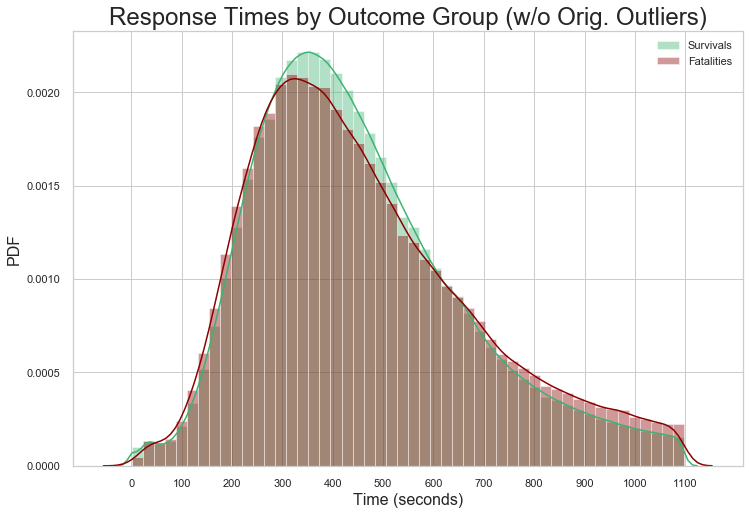

In [76]:
# Visualize distribution of response times for outcome groups on same axis
fig3B, ax3B = plt.subplots(figsize=(12,8))
ax3B = sb.distplot(rspn_tm_S.response_time,color='#3CB371',label='Survivals')
ax3B = sb.distplot(rspn_tm_F.response_time,color='#8b0000',label='Fatalities')
ax3B.set_title('Response Times by Outcome Group (w/o Orig. Outliers)',size=24)
ax3B.set_xlabel('Time (seconds)',size=16)
ax3B.set_xticks([100*i for i in range(12)])
ax3B.set_ylabel('PDF',size=16)

plt.legend()
#plt.savefig('../graphics/CP1-02_fig03B.png') # Export plot to PNG file
plt.show()

The distributions of the two samples appear similar, but further analysis is required to determine whether or not there is any significant difference between the two groups. [TOC](#TOC)

<a id="Sec03C"></a>
#### 3C: Frequentist Test (Two-Sample) 

Is there a significant difference between the response times of incidents that result in fatalities and those where patients survive? Assuming a 95% confidence interval, the null hypothesis will only be rejected if the resulting test statistic is more than 1.96 standard deviations away from the mean.

+ $\mu_{rspn,F}$ = Mean response time for incidents resulting in fatality

+ $\mu_{rspn,S}$ = Mean response time for incidents resulting in survival
<br>

HYPOTHESIS TEST

$H_0$: $\mu_{rspn,F}$ = $\mu_{rspn,S}$ (the mean response times are the same)

$H_A$: $\mu_{rspn,F}$ $\neq$ $\mu_{rspn,S}$ (the mean response times are different)

In [24]:
# Calculate means for samples
mu_F = np.mean(rspn_tm_F)
mu_S = np.mean(rspn_tm_S)

# Calculate standard error (se) for each sample
se_F = stats.sem(rspn_tm_F)
se_S = stats.sem(rspn_tm_S)

# Calculate the margin of error (me) for a 95% C.I. per sample
me_F = 1.96*se_F
me_S = 1.96*se_S

# Calculate the upper and lower bounds for each 95% C.I.
upper_F = mu_F + me_F
lower_F = mu_F - me_F
upper_S = mu_S + me_S
lower_S = mu_S - me_S

# Print results
print('Mean Response Time for Fatalities:    {:4f}'.format(mu_F))
print('Standard Error - Fatalities:          {:4f}'.format(se_F))
print('95% Confidence Interval - Fatalities: {:4f} to {:4f}'.format(lower_F,upper_F))
print()
print('Mean Response Time for Survivals:    {:4f}'.format(mu_S))
print('Standard Error - Survivals:          {:4f}'.format(se_S))
print('95% Confidence Interval - Survivals: {:4f} to {:4f}'.format(lower_S,upper_S))

Mean Response Time for Fatalities:    462.107694
Standard Error - Fatalities:          0.410463
95% Confidence Interval - Fatalities: 461.303187 to 462.912200

Mean Response Time for Survivals:    453.858652
Standard Error - Survivals:          0.077846
95% Confidence Interval - Survivals: 453.706073 to 454.011230


In [25]:
# t-test
t_stat, t_pval = stats.ttest_ind(rspn_tm_F,rspn_tm_S,equal_var=False)
print('z-statistic: {:4f}\np-value: {}'.format(abs(t_stat),t_pval))

z-statistic: 19.744977
p-value: 1.0010596590658166e-86


In [26]:
# z-test
z_stat,z_pval = ztest(rspn_tm_F,rspn_tm_S,alternative='two-sided')
print('z-statistic: {:4f}\np-value: {}'.format(abs(z_stat),z_pval))

z-statistic: 20.954708
p-value: 1.6996721271663527e-97
